# Построение простого нестационарного решения уравнения фильтрации на основе решения в пространстве Лапласа

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Хабибуллин Ринат 2021 г.

Рассматривается уравнение фильтрации в безразмерных переменных 

$$ \frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D} \frac{ \partial{ \left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) } }{ \partial{r_D} } $$

где введены следующие безразмерные переменные
* $r_D$ - безразмерное расстояние от центра скважины
* $t_D$ - безразмерное время
* $p_D$ - безразмерное давление

Соответствующие определения безразмерных переменных

$$ r_D = \frac{r}{r_w} $$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}$$
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p_{wf} \right) $$

где в свою очередь 
* $q_s$ - дебит скважины на поверхности, приведенный к нормальным условиям м3/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м3/м3
* $p_i$ - начальное давление в пласте, атм
* $p_{wf}$ - давление забойное, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм

Решение такого уравнение может быть получено с использованием <a href="https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B0%D0%BF%D0%BB%D0%B0%D1%81%D0%B0"
                        target="_blank" rel="noreferrer noopener">преобразования Лапласа</a>.

$$ L \left [ f(t) \right] = \tilde{f}(s) = \int_{0}^{\infty}f(t)e^{-st}dt $$

где $s$ параметр пространства Лапласа соответствующий времени.

Решение для бесконечно малого радиуса скважины в пространстве Лапласа будет иметь вид

$$ \tilde{p}_D(s) = \frac{1}{s} K_0 \left( r_D \sqrt s  \right) $$

где 

$K_0$ - <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"
                        target="_blank" rel="noreferrer noopener">модифицированная функция Бесселя&nbsp;</a>
                        
Хотя решения в пространстве Лапласа относительно легко получить -- обратная процедура получения решения в исходных координатах на основе решения в пространстве Лапласа оказывается сложнее. Аналитически это не всегда удается сделать, чаще эту процедуру проводят численно. 

Для численного обратного преобразования Лапласа мы будет использовать библиотеку <a href="https://mpmath.org/doc/current/calculus/inverselaplace.html"> mpmath </a>. Там же можно найти численную реализацию функций Бесселя

In [1]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 15; mp.pretty = True

## Построение графика модифицированной функции Бесселя второго рода $K_0$

In [2]:
# пример вызова расчета функции Бесселя
print(besselk(0,1))
%timeit besselk(0,1)

0.421024438240708
1 ms ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Можно обратить внимание, что реализация расчетов с использованием mpmath относительно медленная. Например расчет с использованием функций scipy значительно быстрее, однако он не совместим с реализацией обратного преобразования Лапласа в пакете mpmath.

In [3]:
import scipy.special as sc

In [4]:
# пример вызова расчета функции Бесселя с использованием пакета scipy
print(sc.kn(0,1))
%timeit sc.kn(0,1)

0.42102443824070834
1.13 µs ± 15.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Построение графика

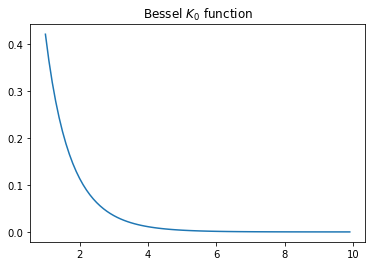

In [5]:
x = np.arange(1,10,0.1)
y = [besselk(0, xi) for xi in x]

plt.plot(x,y)
plt.title("Bessel $K_0$ function")
plt.show()

## Решение с использованием обратного преобразования Лапласа

In [6]:
# решение линейного стока в пространстве Лапласа
def pd_lapl(s, rd=1):
  return 1/s * besselk(0, rd*s**0.5)

In [7]:
# пример расчета с использованием функции в пространстве Лапласа
print(pd_lapl(1, 1))

0.421024438240708


Для численного обратного преобразования Лапласа мы будет использовать библиотеку <a href="https://mpmath.org/doc/current/calculus/inverselaplace.html"> mpmath </a>. Для этого используем функцию invertlaplace.

для функции можно указать несколько аргументов. Первый `method` регулирует метод расчета. Традиционно при анализе гидродинамических исследований используется метод Стефеста. Именно он реализован в Excel версия расчетных модулей Unifloc VBA. В библиотеке mpmath реализованы и другие методы. Предствляет интерес исследование применимости различных методов с точки зрения скорости расчета, точности и применимости к различным решениям. По умолчанию используется `method='talbot'`. Второй аргумент `degree` регулирует желаемую точность расчета и заметно влияет на скорость проведения расчета.

In [8]:
invertlaplace(pd_lapl,1,method='talbot')

0.522141317221869

Оценим скорости проведения расчета


In [9]:
%timeit pd_lapl(1, 1)

1.01 ms ± 7.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit invertlaplace(pd_lapl,1,method='talbot')

101 ms ± 432 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit invertlaplace(pd_lapl,1,method='talbot', degree = 5)
%timeit invertlaplace(pd_lapl,1,method='talbot', degree = 10)
%timeit invertlaplace(pd_lapl,1,method='talbot', degree = 15)

7.41 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.2 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.5 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit invertlaplace(pd_lapl,1,method='stehfest', degree = 5)
%timeit invertlaplace(pd_lapl,1,method='stehfest', degree = 10)
%timeit invertlaplace(pd_lapl,1,method='stehfest', degree = 15)

5.59 ms ± 79.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Хорошо бы кроме времени расчета сравнить и результаты (по идее они должны совпадать, но все же можно и проверить)

In [24]:
# реализация функции расчета безразмерного давления на основе преобразования Лапласа
def pd_line_source_lapl(rd, td):
  fp = lambda p: pd_lapl(p, rd)
  return invertlaplace(fp, td, method='stehfest', degree = 5)

In [15]:
%timeit pd_line_source_lapl(1, 1)

5.84 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

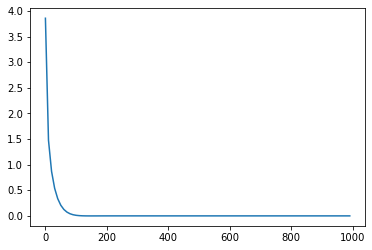

In [16]:
t_d=1000
r_d = np.arange(1, 1000, 10)
p_d = [pd_line_source_lapl(ri, t_d) for ri in r_d]

plt.plot(r_d, p_d)
plt.plot

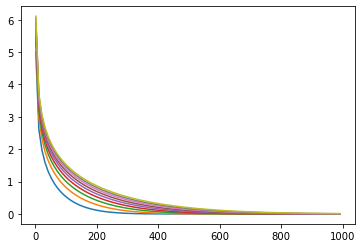

In [18]:
# Пример построения сразу нескольких решений на одном графике
# Зададим массив (итератор) определяющий количество графиков которые мы хотим построить
n=np.arange(1,10,1)
# зададим диапазон изменения расстояний и количество точек для которых строятся кривые
r_d = np.arange(1, 1000, 10)

# цикл расчета. Полезно понимать тут, что функция pd_line_source_lapl будет вызываться число раз равное
# произведению количества графиков на количество точек. 
# для сложных функций это время может оказаться достаточно заметным
for i in n:
    t_d = 10000*i
      # здесь используем расчет заполнения массива с использованием итератора python - 
      # не самый быстрый вариант для этой функции, но работает
    plt.plot(r_d, [pd_line_source_lapl(ri, t_d) for ri in r_d])
plt.show()

## Сравнение решения с использованием Ei и через пространство Лапласа

# Решение линейного стока уравнения фильтрации
def pd_ei(rd, td):
  return -1/2*sc.expi(-rd**2 / 4 / td)

Построим график отклонения расчета Ei от расчета mpamath

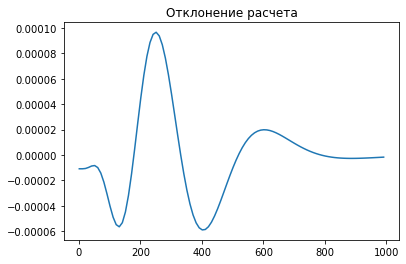

In [25]:
td = 10000
pd_expi_array = np.array([pd_ei(ri, td) for ri in r_d])
pd_lapl_array = np.array([pd_line_source_lapl(ri, td) for ri in r_d])

dpd = pd_lapl_array - pd_expi_array
plt.plot(r_d, dpd)
plt.title("Отклонение расчета")
plt.show()

Проверьте как изменится отклонение при изменении точности расчета обратного преобразования Лапласа в функции pd_line_source_lapl

Сравним еще и скорости расчетов 

In [27]:
%timeit pd_ei(2, 1000)

990 ns ± 18.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [28]:
%timeit pd_line_source_lapl(2, 1000)

5.89 ms ± 50.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Задания для самостоятельной работы

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте двумерную тепловую карту распределения давления в пласте для модели. 
2. Попробуйте найти другую реализацию расчета обратного преобразования Лапласа на python и сравнете ее с текущим примером на mpmath по скорости и точности (поисковая задача, ответ скорее всего есть, но на текущий момент не известен) 
3. Создайте свою реализацию расчета численного обратного преобразования Лапласа, которая могла бы работать с функциями scipy и проверьте ее на скорость и точность (программистская задача, в качестве базы можно взять реализацию расчета преобразования Стефеста из unifloc VBA)
